In [1]:
import json
import torch
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger

# Files we need

In [2]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_304_199_C-0065_C_.hdf5"
reg_lambda = 1189.53

saved_model_raw = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_304_199_C-0065_C_/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_304_199_C-0065_C_/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/study_error"

In [31]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5"
reg_lambda = 573.84

saved_model_raw = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_303_199_C-0065_C_/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_303_199_C-0065_C_/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/study_error"

In [54]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_310_0100_C-0656_A_.hdf5"
reg_lambda = 793.41

saved_model_raw = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_310_0100_C-0656_A_/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_310_0100_C-0656_A_/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/study_error"

In [68]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_351_096_C-0679_A_.hdf5"
reg_lambda = 382.7

saved_model_raw = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_351_096_C-0679_A_/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/"\
    "HD22049_351_096_C-0679_A_/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/05_understand_fine_tuning/01_train_test_split/study_error"

# Load the data

In [69]:
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=dataset_hdf5_file,
        data_tag="object",
        psf_template_tag="psf_template",
        para_tag="header_object/PARANG")

science_data = science_data[:, 17:-17, 17:-17]

science_data_train = science_data[0::2]
angles_train = raw_angles[0::2]

science_data_test = science_data[1::2]
angles_test = raw_angles[1::2]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

# Restore the two models

In [70]:
s4_model_raw = S4(
    data_cube=science_data_train,
    parang=angles_train,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=reg_lambda,
    noise_normalization="normal",
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=work_dir,
    verbose=True)

Creating right reason mask ... [DONE]


In [71]:
s4_noise_raw = S4Noise.load(saved_model_raw)
s4_model_raw.noise_model = s4_noise_raw.float()

Creating right reason mask ... [DONE]


In [72]:
s4_model_fine_tuned = S4(
    data_cube=science_data,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=reg_lambda,
    noise_normalization="normal",
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=work_dir,
    verbose=True)

Creating right reason mask ... [DONE]


In [73]:
s4_noise_fine_tuned = S4Noise.load(saved_model_fine_tuned)
s4_model_fine_tuned.noise_model = s4_noise_fine_tuned.float()

Creating right reason mask ... [DONE]


# Compute the loss terms

In [74]:
def compute_noise_estimate(
    model_in, 
    dataset_in):
    
    # get all the data
    x_train = torch.from_numpy(dataset_in).float()
    x_mu = torch.mean(x_train, axis=0)
    x_std = torch.std(x_train, axis=0)
    x_norm = (x_train - x_mu) / x_std
    
    # run the forward pass
    science_norm_flatten = x_norm.view(x_norm.shape[0], -1)
    model_in.noise_model.compute_betas()
    noise_estimate = model_in.noise_model(science_norm_flatten)
    
    return x_norm.view(-1, 107, 107).detach().numpy(), noise_estimate.view(-1, 107, 107).detach().numpy()

In [75]:
data_raw_train, noise_raw_train = compute_noise_estimate(s4_model_raw, science_data_train)
data_fine_tuned_train, noise_fine_tuned_train = compute_noise_estimate(s4_model_fine_tuned, science_data_train)

In [76]:
data_raw_test, noise_raw_test = compute_noise_estimate(s4_model_raw, science_data_test)
data_fine_tuned_test, noise_fine_tuned_test = compute_noise_estimate(s4_model_fine_tuned, science_data_test)

## The loss terms

In [77]:
print("Raw Train error: " + str(np.sum((data_raw_train - noise_raw_train)**2)))
print("Fine-tuned Train error: " + str(np.sum((data_fine_tuned_train - noise_fine_tuned_train)**2)))

print("Raw Test error: " + str(np.sum((data_raw_test - noise_raw_test)**2)))
print("Fine-tuned Test error: " + str(np.sum((data_fine_tuned_test - noise_fine_tuned_test)**2)))

Raw Train error: 114558590.0
Fine-tuned Train error: 114407040.0
Raw Test error: 144964980.0
Fine-tuned Test error: 144867180.0


In [78]:
print("Regularization loss raw: " +
      str(np.sum((s4_model_raw.noise_model.betas_raw **2).detach().numpy())))
print("Regularization loss fine-tuned: " +
      str(np.sum((s4_model_fine_tuned.noise_model.betas_raw **2).detach().numpy())))

Regularization loss raw: 22797.41
Regularization loss fine-tuned: 22794.04


# Plot the difference in weights

In [79]:
beta_difference = s4_model_fine_tuned.noise_model.betas - s4_model_raw.noise_model.betas

In [80]:
most_changed_region = torch.max(torch.abs(beta_difference), axis=0)[0].reshape(107, 107)

(-0.5, 106.5, 106.5, -0.5)

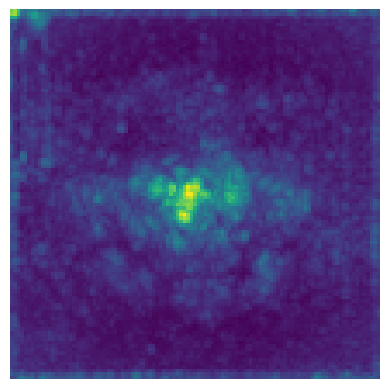

In [81]:
plt.imshow(most_changed_region.detach().numpy())
plt.axis("off")